In [ ]:
!pip install transformers
!pip install huggingface_hub
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 43.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
!pip install spacy
!python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 83.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Personal Transformer
import spacy
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
raw_datasets = load_dataset("ashwinradhe/dl_dataset")
small_train_dataset = raw_datasets['train'].select(range(100000))
SRC_LANGUAGE = "en"
TRG_LANGUAGE = "fr"
tokenizer_en = get_tokenizer('spacy', language='en_core_web_sm')
tokenizer_fr= get_tokenizer('spacy', language='fr_core_news_sm')
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']
def tokenize_and_build_vocab(data, tokenizer):
    tokenized_data = [tokenizer(sentence) for sentence in data]
    vocab = build_vocab_from_iterator(tokenized_data,min_freq=1, specials=special_symbols,special_first=True)
    vocab.set_default_index(vocab['<unk>'])
    return vocab, tokenized_data
vocab_en, tokenized_data_en = tokenize_and_build_vocab(small_train_dataset['English Sentence'], tokenizer_en)
vocab_fr, tokenized_data_fr = tokenize_and_build_vocab(small_train_dataset['French Sentence'], tokenizer_fr)
def numericalize_and_pad(tokenized_data, vocab):
    numericalized_data = [torch.tensor(vocab.lookup_indices(sentence)) for sentence in tokenized_data]
    padded_data = pad_sequence(numericalized_data, batch_first=True, padding_value=vocab['<pad>'])
    return padded_data
padded_data_en = numericalize_and_pad(tokenized_data_en, vocab_en)
padded_data_fr = numericalize_and_pad(tokenized_data_fr, vocab_fr)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/1825077 [00:00<?, ? examples/s]

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader
dataset = torch.utils.data.TensorDataset(padded_data_en, padded_data_fr)
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

##Relative positional Encoding

##ADAM
##Cross Entropy Loss

In [ ]:
import torch
from torch import nn
import math
class RelativePositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.emb_size = emb_size
        self.max_len = max_len
        relative_positions = torch.arange(-max_len, max_len + 1, dtype=torch.long)
        scales = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        relative_positional_encodings = torch.zeros((2 * max_len + 1, emb_size))
        relative_positional_encodings[:, 0::2] = torch.sin(relative_positions.unsqueeze(-1) * scales)
        relative_positional_encodings[:, 1::2] = torch.cos(relative_positions.unsqueeze(-1) * scales)
        self.register_buffer('relative_positional_encodings', relative_positional_encodings)

    def forward(self, length: int):
        center_pos = self.max_len
        return self.relative_positional_encodings[center_pos - length + 1 : center_pos + 1]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = RelativePositionalEncoding(embed_size, max_len=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding(src.size(1))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt.size(1))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_fn, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss, validation_loss,model = train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 5.0127, Validation Loss: 4.4371
Epoch 2, Training Loss: 4.2496, Validation Loss: 4.1797
Epoch 3, Training Loss: 3.9744, Validation Loss: 3.9593
Epoch 4, Training Loss: 3.7733, Validation Loss: 3.8172
Epoch 5, Training Loss: 3.6303, Validation Loss: 3.7260
Epoch 6, Training Loss: 3.5203, Validation Loss: 3.6496
Epoch 7, Training Loss: 3.4307, Validation Loss: 3.5954
Epoch 8, Training Loss: 3.3579, Validation Loss: 3.5468
Epoch 9, Training Loss: 3.2965, Validation Loss: 3.5131
Epoch 10, Training Loss: 3.2424, Validation Loss: 3.4789


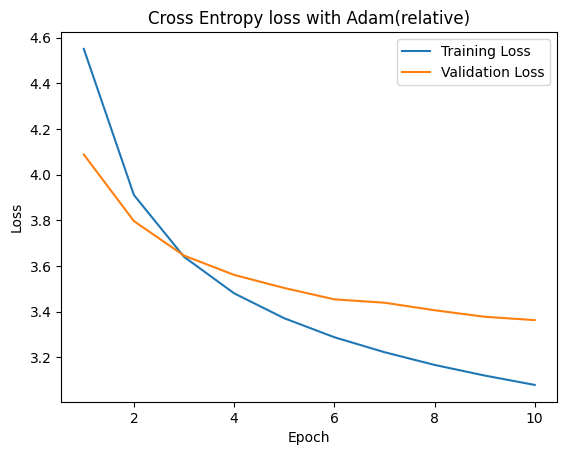

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss) + 1)
plt.plot(epochs, training_loss, label='Training Loss')
plt.plot(epochs, validation_loss, label='Validation Loss')
plt.title('Cross Entropy loss with Adam(relative)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_metrics = {"training_loss": training_loss, "validation_loss":validation_loss}
torch.save(model_metrics, '/content/drive/MyDrive/Adam/relative_positional_encoding/crossentropyloss/model_metrics.pkl')

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Adam/relative_positional_encoding/crossentropyloss/model_weights.pt')
torch.save(model, '/content/drive/MyDrive/Adam/relative_positional_encoding/crossentropyloss/model.pkl')

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/Model_file_large_epoch_1/model_label_smoothning.pt'))

<All keys matched successfully>

In [ ]:
import torch
model = torch.load('/content/drive/MyDrive/Model_file_large_epoch_1/model_label_smoothning.pt')

##Cross Entropy Loss with label smoothning

In [ ]:
import torch
from torch import nn
import math
class RelativePositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.emb_size = emb_size
        self.max_len = max_len
        relative_positions = torch.arange(-max_len, max_len + 1, dtype=torch.long)
        scales = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        relative_positional_encodings = torch.zeros((2 * max_len + 1, emb_size))
        relative_positional_encodings[:, 0::2] = torch.sin(relative_positions.unsqueeze(-1) * scales)
        relative_positional_encodings[:, 1::2] = torch.cos(relative_positions.unsqueeze(-1) * scales)
        self.register_buffer('relative_positional_encodings', relative_positional_encodings)

    def forward(self, length: int):
        center_pos = self.max_len
        return self.relative_positional_encodings[center_pos - length + 1 : center_pos + 1]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = RelativePositionalEncoding(embed_size, max_len=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding(src.size(1))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt.size(1))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_cel = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.Adam(model_cel.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_cel = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX,label_smoothing=0.5)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_cel.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_cel(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_cel(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_cel, validation_loss_cel,model_cel = train_and_evaluate(model_cel, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_cel, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 8.3648, Validation Loss: 8.1555
Epoch 2, Training Loss: 8.0795, Validation Loss: 8.0254
Epoch 3, Training Loss: 7.9764, Validation Loss: 7.9248
Epoch 4, Training Loss: 7.9042, Validation Loss: 7.8595
Epoch 5, Training Loss: 7.8530, Validation Loss: 7.8193
Epoch 6, Training Loss: 7.8151, Validation Loss: 7.7863
Epoch 7, Training Loss: 7.7846, Validation Loss: 7.7716
Epoch 8, Training Loss: 7.7598, Validation Loss: 7.7422
Epoch 9, Training Loss: 7.7394, Validation Loss: 7.7320
Epoch 10, Training Loss: 7.7217, Validation Loss: 7.7122


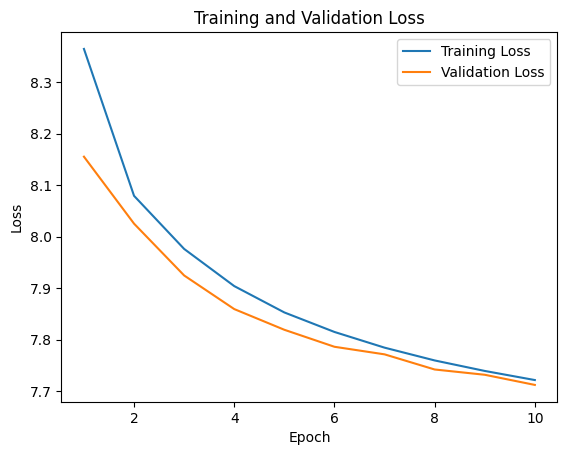

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_cel) + 1)
plt.plot(epochs,training_loss_cel, label='Training Loss')
plt.plot(epochs,validation_loss_cel, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

In [ ]:
model_metrics_cel = {'training_loss':training_loss_cel, 'validation_loss':validation_loss_cel}
torch.save(model_metrics_cel, '/content/drive/MyDrive/Adam/relative_positional_encoding/crossentropylosswithlabelsmoothning/model_metrics_cel.pkl')

In [ ]:
torch.save(model_cel, '/content/drive/MyDrive/Adam/relative_positional_encoding/crossentropylosswithlabelsmoothning/model_cel.pt')
torch.save(model_cel.state_dict(), '/content/drive/MyDrive/Adam/relative_positional_encoding/crossentropylosswithlabelsmoothning/model_cel_state_dict.pkl')

##NLLLoss

In [ ]:
import torch
from torch import nn
import math
class RelativePositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.emb_size = emb_size
        self.max_len = max_len
        relative_positions = torch.arange(-max_len, max_len + 1, dtype=torch.long)
        scales = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        relative_positional_encodings = torch.zeros((2 * max_len + 1, emb_size))
        relative_positional_encodings[:, 0::2] = torch.sin(relative_positions.unsqueeze(-1) * scales)
        relative_positional_encodings[:, 1::2] = torch.cos(relative_positions.unsqueeze(-1) * scales)
        self.register_buffer('relative_positional_encodings', relative_positional_encodings)

    def forward(self, length: int):
        center_pos = self.max_len
        return self.relative_positional_encodings[center_pos - length + 1 : center_pos + 1]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = RelativePositionalEncoding(embed_size, max_len=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding(src.size(1))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt.size(1))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_sc = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
from torch.nn import functional as F
optimizer = torch.optim.Adam(model_sc.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_sc = nn.NLLLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sc.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            logits = F.log_softmax(logits, dim=-1)
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_sc(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                logits = F.log_softmax(logits, dim=-1)
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_sc(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_sc, validation_loss_sc,model_sc = train_and_evaluate(model_sc, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_sc, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 5.0150, Validation Loss: 4.4339
Epoch 2, Training Loss: 4.2513, Validation Loss: 4.2237
Epoch 3, Training Loss: 3.9683, Validation Loss: 4.0076
Epoch 4, Training Loss: 3.7638, Validation Loss: 3.8217
Epoch 5, Training Loss: 3.6163, Validation Loss: 3.6897
Epoch 6, Training Loss: 3.5050, Validation Loss: 3.6080
Epoch 7, Training Loss: 3.4155, Validation Loss: 3.5568
Epoch 8, Training Loss: 3.3442, Validation Loss: 3.5296
Epoch 9, Training Loss: 3.2825, Validation Loss: 3.4858
Epoch 10, Training Loss: 3.2302, Validation Loss: 3.4528


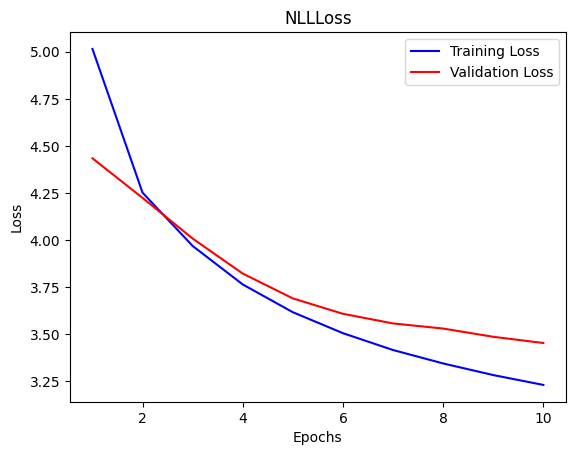

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_sc) + 1)
plt.plot(epochs, training_loss_sc, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_sc, 'r', label='Validation Loss')
plt.title('NLLLoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_metrics_sc = {'training_loss':training_loss_sc, 'validation_loss':validation_loss_sc}
torch.save(model_metrics_sc, '/content/drive/MyDrive/Adam/relative_positional_encoding/sparsecategoricalcrossentropy/model_metrics_sc.pkl')

In [ ]:
torch.save(model_sc.state_dict(), '/content/drive/MyDrive/Adam/relative_positional_encoding/sparsecategoricalcrossentropy/model_weights_sc.pkl')
torch.save(model_sc, '/content/drive/MyDrive/Adam/relative_positional_encoding/sparsecategoricalcrossentropy/model_sc.pt')

##Optimizer AdamW

In [ ]:
import torch
from torch import nn
import math
class RelativePositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.emb_size = emb_size
        self.max_len = max_len
        relative_positions = torch.arange(-max_len, max_len + 1, dtype=torch.long)
        scales = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        relative_positional_encodings = torch.zeros((2 * max_len + 1, emb_size))
        relative_positional_encodings[:, 0::2] = torch.sin(relative_positions.unsqueeze(-1) * scales)
        relative_positional_encodings[:, 1::2] = torch.cos(relative_positions.unsqueeze(-1) * scales)
        self.register_buffer('relative_positional_encodings', relative_positional_encodings)

    def forward(self, length: int):
        center_pos = self.max_len
        return self.relative_positional_encodings[center_pos - length + 1 : center_pos + 1]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = RelativePositionalEncoding(embed_size, max_len=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding(src.size(1))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt.size(1))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_adamw = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.AdamW(model_adamw.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_adamw = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_adamw.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_adamw(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_adamw(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_adamw, validation_loss_adamw,model_adamw = train_and_evaluate(model_adamw, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_adamw, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 5.0098, Validation Loss: 4.4297
Epoch 2, Training Loss: 4.2482, Validation Loss: 4.2305
Epoch 3, Training Loss: 3.9928, Validation Loss: 4.0139
Epoch 4, Training Loss: 3.8060, Validation Loss: 3.8717
Epoch 5, Training Loss: 3.6604, Validation Loss: 3.7661
Epoch 6, Training Loss: 3.5428, Validation Loss: 3.6701
Epoch 7, Training Loss: 3.4472, Validation Loss: 3.6068
Epoch 8, Training Loss: 3.3672, Validation Loss: 3.5603
Epoch 9, Training Loss: 3.3005, Validation Loss: 3.5214
Epoch 10, Training Loss: 3.2415, Validation Loss: 3.4907


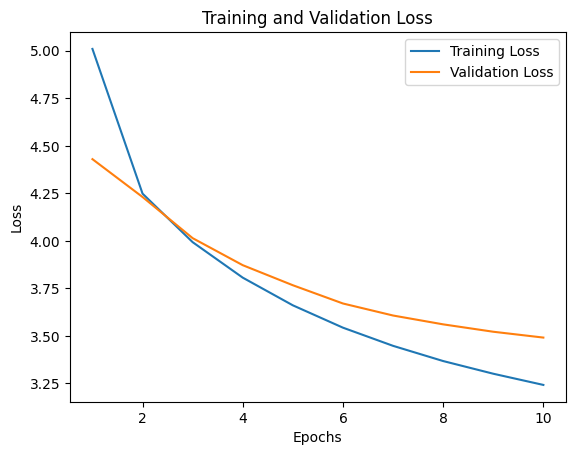

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_adamw) + 1)
plt.plot(epochs, training_loss_adamw, label='Training Loss')
plt.plot(epochs, validation_loss_adamw, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
model_adamw_metrics = {'training_loss': training_loss_adamw, 'validation_loss': validation_loss_adamw}
torch.save(model_adamw_metrics, '/content/drive/MyDrive/Adamw/relative_positional_encoding/crossentropyloss/model_adamw_metrics.pkl')

In [ ]:
torch.save(model_adamw.state_dict(), '/content/drive/MyDrive/Adamw/relative_positional_encoding/crossentropyloss/model_metrics_adamw.pkl')
torch.save(model_adamw, '/content/drive/MyDrive/Adamw/relative_positional_encoding/crossentropyloss/model_adamw.pt')

##Crossentropywithlabelsmoothning

In [ ]:
import torch
from torch import nn
import math
class RelativePositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.emb_size = emb_size
        self.max_len = max_len
        relative_positions = torch.arange(-max_len, max_len + 1, dtype=torch.long)
        scales = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        relative_positional_encodings = torch.zeros((2 * max_len + 1, emb_size))
        relative_positional_encodings[:, 0::2] = torch.sin(relative_positions.unsqueeze(-1) * scales)
        relative_positional_encodings[:, 1::2] = torch.cos(relative_positions.unsqueeze(-1) * scales)
        self.register_buffer('relative_positional_encodings', relative_positional_encodings)

    def forward(self, length: int):
        center_pos = self.max_len
        return self.relative_positional_encodings[center_pos - length + 1 : center_pos + 1]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = RelativePositionalEncoding(embed_size, max_len=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding(src.size(1))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt.size(1))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_adamw_c = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.AdamW(model_adamw_c.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_adamw_c = nn.CrossEntropyLoss(ignore_index=PAD_IDX,label_smoothing=0.5)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_adamw_c.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_adamw_c(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_adamw_c(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_adamw_c, validation_loss_adamw_c,model_adamw_c = train_and_evaluate(model_adamw_c, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_adamw_c, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 8.3707, Validation Loss: 8.1696
Epoch 2, Training Loss: 8.0832, Validation Loss: 8.0195
Epoch 3, Training Loss: 7.9791, Validation Loss: 7.9210
Epoch 4, Training Loss: 7.9039, Validation Loss: 7.8687
Epoch 5, Training Loss: 7.8512, Validation Loss: 7.8221
Epoch 6, Training Loss: 7.8123, Validation Loss: 7.7859
Epoch 7, Training Loss: 7.7807, Validation Loss: 7.7603
Epoch 8, Training Loss: 7.7550, Validation Loss: 7.7408
Epoch 9, Training Loss: 7.7334, Validation Loss: 7.7281
Epoch 10, Training Loss: 7.7150, Validation Loss: 7.7103


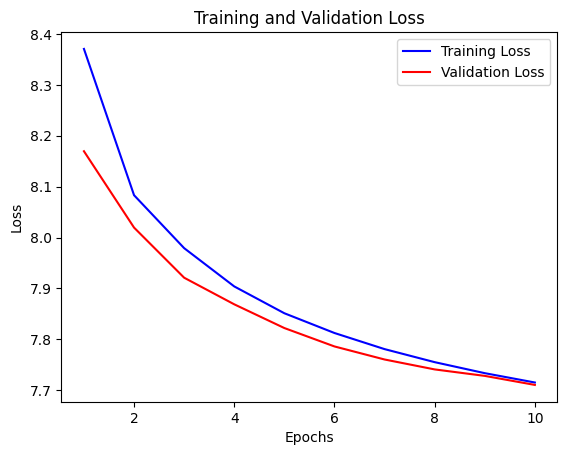

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_adamw_c) + 1)
plt.plot(epochs, training_loss_adamw_c, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_adamw_c, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model_adamw_c.state_dict(), '/content/drive/MyDrive/Adamw/relative_positional_encoding/crossentropywithlabelsmoothning/model_state_adamw_c.pkl')
torch.save(model_adamw_c, '/content/drive/MyDrive/Adamw/relative_positional_encoding/crossentropywithlabelsmoothning/model_adamw_c.pt')

In [ ]:
model_metrcis_adamw_c = {'training_loss': training_loss_adamw_c, 'validation_loss': validation_loss_adamw_c}
torch.save(model_metrcis_adamw_c, '/content/drive/MyDrive/Adamw/relative_positional_encoding/crossentropywithlabelsmoothning/model_metrics_adamw_c.pth')

##NLLLoss

In [ ]:
import torch
from torch import nn
import math
class RelativePositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.emb_size = emb_size
        self.max_len = max_len
        relative_positions = torch.arange(-max_len, max_len + 1, dtype=torch.long)
        scales = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        relative_positional_encodings = torch.zeros((2 * max_len + 1, emb_size))
        relative_positional_encodings[:, 0::2] = torch.sin(relative_positions.unsqueeze(-1) * scales)
        relative_positional_encodings[:, 1::2] = torch.cos(relative_positions.unsqueeze(-1) * scales)
        self.register_buffer('relative_positional_encodings', relative_positional_encodings)

    def forward(self, length: int):
        center_pos = self.max_len
        return self.relative_positional_encodings[center_pos - length + 1 : center_pos + 1]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = RelativePositionalEncoding(embed_size, max_len=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding(src.size(1))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt.size(1))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_adamw_n = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.AdamW(model_adamw_n.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_adamw_n = nn.NLLLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_adamw_n.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            logits = F.log_softmax(logits, dim=-1)
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_adamw_n(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                logits = F.log_softmax(logits, dim=-1)
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_adamw_n(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_adamw_n, validation_loss_adamw_n,model_adamw_n = train_and_evaluate(model_adamw_n, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_adamw_n, epochs=10)

Epoch 1, Training Loss: 5.0177, Validation Loss: 4.4507
Epoch 2, Training Loss: 4.2674, Validation Loss: 4.2116
Epoch 3, Training Loss: 4.0120, Validation Loss: 4.0866
Epoch 4, Training Loss: 3.8325, Validation Loss: 3.9463
Epoch 5, Training Loss: 3.6983, Validation Loss: 3.8586
Epoch 6, Training Loss: 3.5904, Validation Loss: 3.7987
Epoch 7, Training Loss: 3.5000, Validation Loss: 3.7616
Epoch 8, Training Loss: 3.4152, Validation Loss: 3.7398
Epoch 9, Training Loss: 3.3428, Validation Loss: 3.7167
Epoch 10, Training Loss: 3.2809, Validation Loss: 3.7038


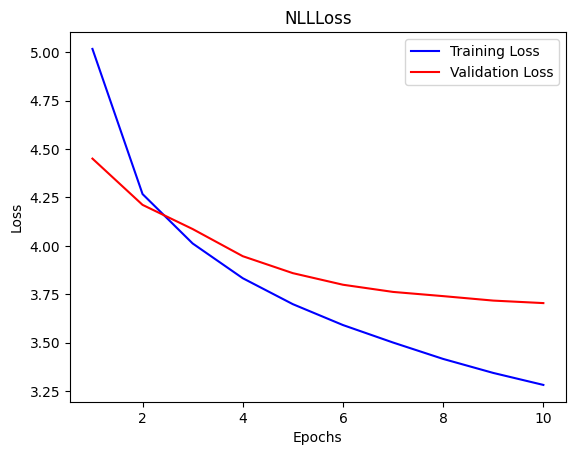

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_adamw_n) + 1)
plt.plot(epochs, training_loss_adamw_n, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_adamw_n, 'r', label='Validation Loss')
plt.title('NLLLoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model_adamw_n.state_dict(), '/content/drive/MyDrive/Adamw/relative_positional_encoding/sparsecategoricalcrossentropy/model_metrics_adamw_n.pt')
torch.save(model_adamw_n, '/content/drive/MyDrive/Adamw/relative_positional_encoding/sparsecategoricalcrossentropy/model_adamw_n.pkl')

In [ ]:
model_metrics_adamw_n = {'training_loss':training_loss_adamw_n,'validation_loss':validation_loss_adamw_n}
torch.save(model_metrics_adamw_n, '/content/drive/MyDrive/Adamw/relative_positional_encoding/sparsecategoricalcrossentropy/model_adamw_n_metrics.pt')

##SGD
##Cross Entropy Loss

In [ ]:
import torch
from torch import nn
import math
class RelativePositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.emb_size = emb_size
        self.max_len = max_len
        relative_positions = torch.arange(-max_len, max_len + 1, dtype=torch.long)
        scales = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        relative_positional_encodings = torch.zeros((2 * max_len + 1, emb_size))
        relative_positional_encodings[:, 0::2] = torch.sin(relative_positions.unsqueeze(-1) * scales)
        relative_positional_encodings[:, 1::2] = torch.cos(relative_positions.unsqueeze(-1) * scales)
        self.register_buffer('relative_positional_encodings', relative_positional_encodings)

    def forward(self, length: int):
        center_pos = self.max_len
        return self.relative_positional_encodings[center_pos - length + 1 : center_pos + 1]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = RelativePositionalEncoding(embed_size, max_len=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding(src.size(1))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt.size(1))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_sgd = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.SGD(model_sgd.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_sgd = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sgd.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_sgd(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_sgd(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_sgd, validation_loss_sgd,model_sgd = train_and_evaluate(model_sgd, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_sgd, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 9.9421, Validation Loss: 9.0078
Epoch 2, Training Loss: 8.4744, Validation Loss: 8.0482
Epoch 3, Training Loss: 7.8379, Validation Loss: 7.6499
Epoch 4, Training Loss: 7.5357, Validation Loss: 7.4232
Epoch 5, Training Loss: 7.3347, Validation Loss: 7.2388
Epoch 6, Training Loss: 7.1598, Validation Loss: 7.0675
Epoch 7, Training Loss: 6.9953, Validation Loss: 6.9112
Epoch 8, Training Loss: 6.8628, Validation Loss: 6.8033
Epoch 9, Training Loss: 6.7689, Validation Loss: 6.7256
Epoch 10, Training Loss: 6.6995, Validation Loss: 6.6655


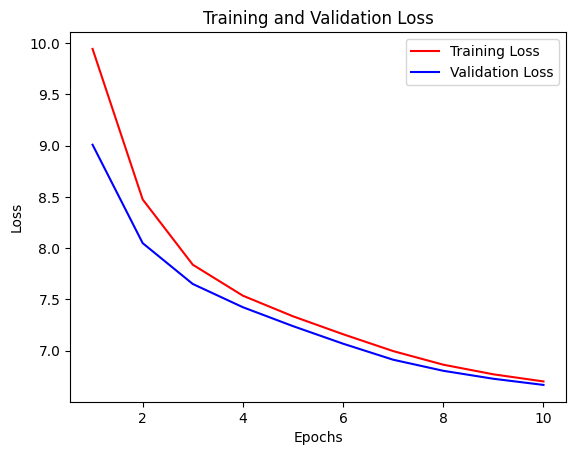

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_sgd) + 1)
plt.plot(epochs, training_loss_sgd, 'r', label='Training Loss')
plt.plot(epochs, validation_loss_sgd, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model_sgd_metrics = {'training_loss': training_loss_sgd, 'validation_loss': validation_loss_sgd}
torch.save(model_sgd_metrics, '/content/drive/MyDrive/SGD/relative_positional_encoding/crossentropyloss/model_sgd_metrics.pkl')

In [ ]:
torch.save(model_sgd, '/content/drive/MyDrive/SGD/relative_positional_encoding/crossentropyloss/model_sgd.pt')
torch.save(model_sgd.state_dict(), '/content/drive/MyDrive/SGD/relative_positional_encoding/crossentropyloss/model_sgd_state.pkl')

##With Label Smoothning

In [ ]:
import torch
from torch import nn
import math
class RelativePositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.emb_size = emb_size
        self.max_len = max_len
        relative_positions = torch.arange(-max_len, max_len + 1, dtype=torch.long)
        scales = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        relative_positional_encodings = torch.zeros((2 * max_len + 1, emb_size))
        relative_positional_encodings[:, 0::2] = torch.sin(relative_positions.unsqueeze(-1) * scales)
        relative_positional_encodings[:, 1::2] = torch.cos(relative_positions.unsqueeze(-1) * scales)
        self.register_buffer('relative_positional_encodings', relative_positional_encodings)

    def forward(self, length: int):
        center_pos = self.max_len
        return self.relative_positional_encodings[center_pos - length + 1 : center_pos + 1]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = RelativePositionalEncoding(embed_size, max_len=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding(src.size(1))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt.size(1))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_sgd_ls = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.SGD(model_sgd_ls.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_sgd_ls = nn.CrossEntropyLoss(ignore_index=PAD_IDX,label_smoothing=0.1)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sgd_ls.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_sgd_ls(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_sgd_ls(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_sgd_ls, validation_loss_sgd_ls,model_sgd_ls = train_and_evaluate(model_sgd_ls, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_sgd_ls, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 10.0613, Validation Loss: 9.2723
Epoch 2, Training Loss: 8.7651, Validation Loss: 8.3469
Epoch 3, Training Loss: 8.1454, Validation Loss: 7.9676
Epoch 4, Training Loss: 7.8697, Validation Loss: 7.7656
Epoch 5, Training Loss: 7.6965, Validation Loss: 7.6166
Epoch 6, Training Loss: 7.5700, Validation Loss: 7.5104
Epoch 7, Training Loss: 7.4754, Validation Loss: 7.4247
Epoch 8, Training Loss: 7.3939, Validation Loss: 7.3406
Epoch 9, Training Loss: 7.3145, Validation Loss: 7.2593
Epoch 10, Training Loss: 7.2456, Validation Loss: 7.2012


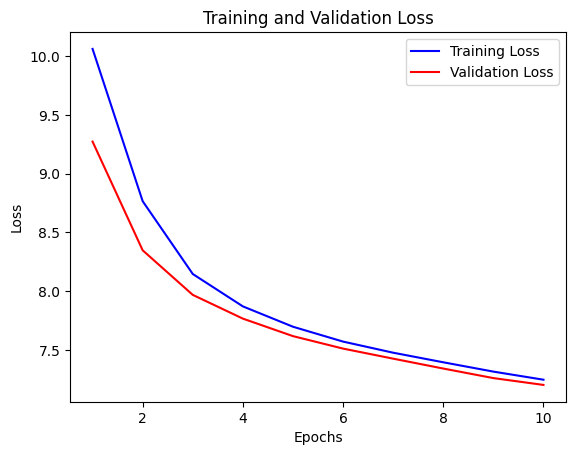

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_sgd_ls) + 1)
plt.plot(epochs, training_loss_sgd_ls, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_sgd_ls, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model_sgd_ls.state_dict(), '/content/drive/MyDrive/SGD/relative_positional_encoding/crossentropywithlabelsmoothning/model_sgd_ls_state.pkl')
torch.save(model_sgd_ls, '/content/drive/MyDrive/SGD/relative_positional_encoding/crossentropywithlabelsmoothning/model_sgd_ls.pt')

In [ ]:
model_sgd_ls_metrics = {'training_loss':training_loss_sgd_ls,'validation_loss':validation_loss_sgd_ls}
torch.save(model_sgd_ls_metrics, '/content/drive/MyDrive/SGD/relative_positional_encoding/crossentropywithlabelsmoothning/model_sgd_ls_metrics.pkl')

##NLLLosss

In [ ]:
import torch
from torch import nn
import math
class RelativePositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, max_len: int = 5000):
        super(RelativePositionalEncoding, self).__init__()
        self.emb_size = emb_size
        self.max_len = max_len
        relative_positions = torch.arange(-max_len, max_len + 1, dtype=torch.long)
        scales = torch.exp(-torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        relative_positional_encodings = torch.zeros((2 * max_len + 1, emb_size))
        relative_positional_encodings[:, 0::2] = torch.sin(relative_positions.unsqueeze(-1) * scales)
        relative_positional_encodings[:, 1::2] = torch.cos(relative_positions.unsqueeze(-1) * scales)
        self.register_buffer('relative_positional_encodings', relative_positional_encodings)

    def forward(self, length: int):
        center_pos = self.max_len
        return self.relative_positional_encodings[center_pos - length + 1 : center_pos + 1]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: torch.Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

class TransformerModel(nn.Module):
    def __init__(self, num_tokens_en, num_tokens_fr, embed_size, nhead, dim_feedforward, max_seq_length):
        super(TransformerModel, self).__init__()
        self.embed_size = embed_size
        self.src_tok_emb = TokenEmbedding(num_tokens_en, embed_size)
        self.tgt_tok_emb = TokenEmbedding(num_tokens_fr, embed_size)
        self.positional_encoding = RelativePositionalEncoding(embed_size, max_len=max_seq_length)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)

        decoder_layer = nn.TransformerDecoderLayer(d_model=embed_size, nhead=nhead, dim_feedforward=dim_feedforward, dropout=0.1)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=3)
        self.generator = nn.Linear(embed_size, num_tokens_fr)

    def encode(self, src, src_mask):
        src_emb = self.src_tok_emb(src) + self.positional_encoding(src.size(1))
        return self.transformer_encoder(src_emb, src_key_padding_mask=src_mask)

    def decode(self, tgt, memory, tgt_mask, tgt_key_padding_mask):
        tgt_emb = self.tgt_tok_emb(tgt) + self.positional_encoding(tgt.size(1))
        return self.transformer_decoder(tgt_emb, memory, tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None, tgt_padding_mask=None):
        memory = self.encode(src, src_padding_mask)
        output = self.decode(tgt, memory, tgt_mask, tgt_padding_mask)
        return self.generator(output)

    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz)).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask
model_sgd_n = TransformerModel(len(vocab_en), len(vocab_fr), embed_size=64, nhead=8, dim_feedforward=1024, max_seq_length=512)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
optimizer = torch.optim.SGD(model_sgd_n.parameters(), lr=0.001)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
seq2seq_loss_sgd_n = nn.NLLLoss(ignore_index=PAD_IDX)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_sgd_n.to(device)
def train_and_evaluate(model, train_dataloader, val_dataloader, test_dataloader, optimizer, loss_function, vocab_en, vocab_fr, epochs=10):
    model.apply(init_weights)
    training_loss = []
    validation_loss = []
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for src, tgt in train_dataloader:
            src, tgt = src.to(device), tgt.to(device)
            src = src.T
            tgt_inp = tgt.T
            tgt_input = tgt_inp[:-1, :]
            tgt_output = tgt_inp[1:, :]
            src_seq_length = src.shape[0]
            tgt_seq_length = tgt_input.shape[0]
            src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
            tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)

            src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
            tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)

            logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
            logits = logits.view(-1, logits.shape[-1])
            logits = F.log_softmax(logits, dim=-1)
            tgt_output = tgt_output.reshape(-1)
            loss = seq2seq_loss_sgd_n(logits, tgt_output)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item() if not torch.isnan(loss) else 0


        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for src, tgt in val_dataloader:
                src, tgt = src.to(device), tgt.to(device)
                src = src.T
                tgt_inp = tgt.T
                tgt_input = tgt_inp[:-1, :]
                tgt_output = tgt_inp[1:, :]
                src_seq_length = src.shape[0]
                tgt_seq_length = tgt_input.shape[0]
                src_mask = torch.zeros(src_seq_length, src_seq_length).to(device).type(torch.bool)
                tgt_mask = model.generate_square_subsequent_mask(tgt_seq_length).to(device)
                src_padding_mask = (src == PAD_IDX).transpose(0, 1).to(device)
                tgt_padding_mask = (tgt_input == PAD_IDX).transpose(0, 1).to(device)
                logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
                logits = logits.view(-1, logits.shape[-1])
                logits = F.log_softmax(logits, dim=-1)
                tgt_output = tgt_output.reshape(-1)
                loss = seq2seq_loss_sgd_n(logits, tgt_output)
                total_val_loss += loss.item()


        avg_val_loss = total_val_loss / len(val_dataloader)
        validation_loss.append(avg_val_loss)
        print(f'Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    return training_loss, validation_loss,model
training_loss_sgd_n, validation_loss_sgd_n,model_sgd_n = train_and_evaluate(model_sgd_n, train_dataloader, val_dataloader, test_dataloader, optimizer, vocab_en, vocab_fr, seq2seq_loss_sgd_n, epochs=10)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5109: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch 1, Training Loss: 9.8905, Validation Loss: 8.9482
Epoch 2, Training Loss: 8.4311, Validation Loss: 8.0059
Epoch 3, Training Loss: 7.8035, Validation Loss: 7.6184
Epoch 4, Training Loss: 7.5130, Validation Loss: 7.3973
Epoch 5, Training Loss: 7.3143, Validation Loss: 7.2164
Epoch 6, Training Loss: 7.1521, Validation Loss: 7.0747
Epoch 7, Training Loss: 7.0194, Validation Loss: 6.9455
Epoch 8, Training Loss: 6.8915, Validation Loss: 6.8079
Epoch 9, Training Loss: 6.7702, Validation Loss: 6.7065
Epoch 10, Training Loss: 6.6884, Validation Loss: 6.6442


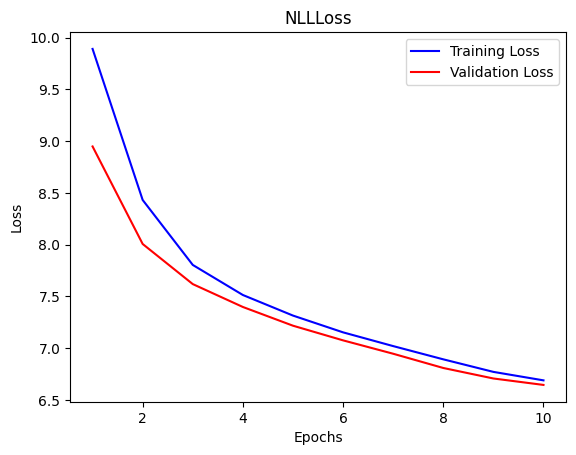

In [ ]:
import matplotlib.pyplot as plt
epochs = range(1, len(training_loss_sgd_n) + 1)
plt.plot(epochs, training_loss_sgd_n, 'b', label='Training Loss')
plt.plot(epochs, validation_loss_sgd_n, 'r', label='Validation Loss')
plt.title('NLLLoss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
torch.save(model_sgd_n.state_dict(), '/content/drive/MyDrive/SGD/relative_positional_encoding/sparsecategoricalcrossentropy/model_sgd_n_state.pkl')
torch.save(model_sgd_n, '/content/drive/MyDrive/SGD/relative_positional_encoding/sparsecategoricalcrossentropy/model_sgd_n.pt')

In [ ]:
model_sgd_n_metrics = {'training loss': training_loss_sgd_n, 'validation loss': validation_loss_sgd_n}
torch.save(model_sgd_n_metrics, '/content/drive/MyDrive/SGD/relative_positional_encoding/sparsecategoricalcrossentropy/model_sgd_n_metrics.pkl')